### Data Notebook: Photostim Neural Dynamics

In [652]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200
import matplotlib.colors as colors
import torch
import torch.nn as nn
import torch.optim as optim
import time

from IPython.display import display, Latex

# Load Data

In [612]:
# trial data
data = np.load('sample_photostim_0113.npy', allow_pickle = True).item()
y_series = data['y_session']/1000
u_series = data['u_session']
num_neurons = y.shape[1]

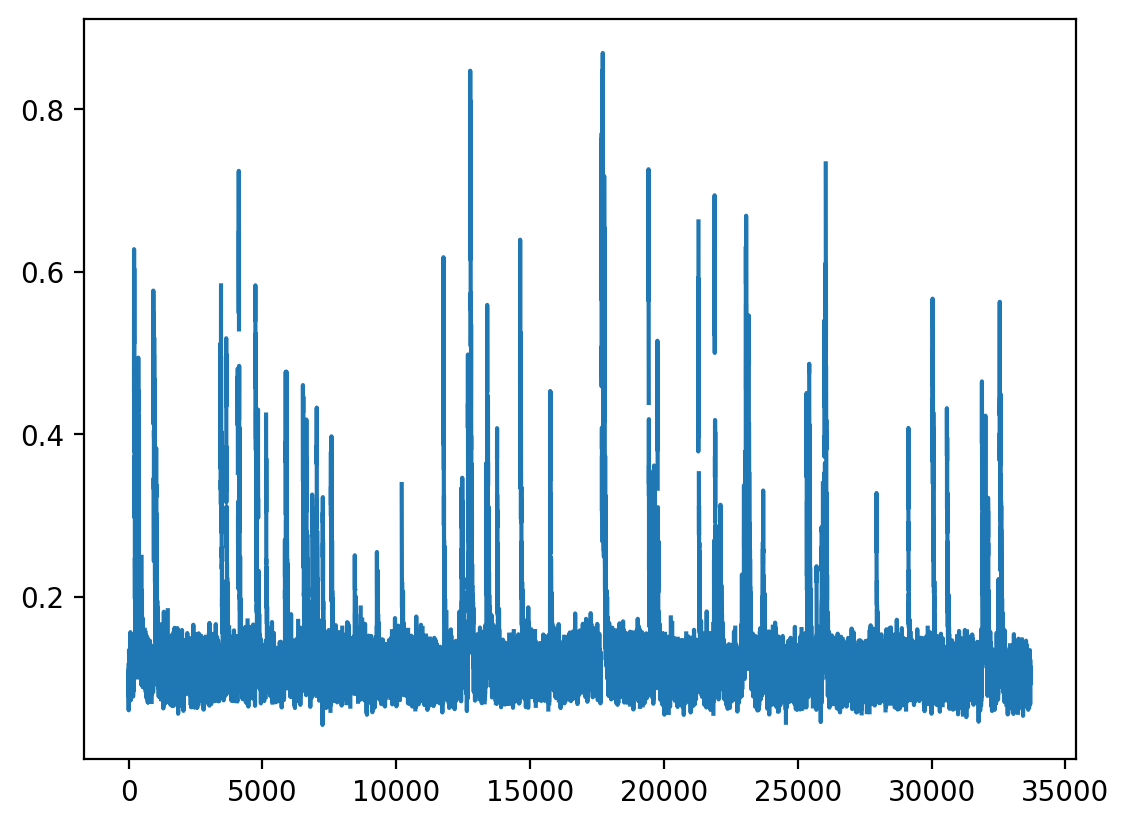

In [613]:
plt.plot(y_series[:,0])

# Markov Parameter Prediction

In [762]:
U = []
Y = []
N = y_series.shape[0]
d = y_series.shape[1]
seq_length = int(0.9*N)
tau = 9
for t in range(tau,seq_length):
    if ~np.isnan( y_series[t+1][0] ):
        U.append( u_series[t-tau:t,:][::-1,:].reshape(-1) )
        Y.append( y_series[t+1] )
U = np.array(U)
U = np.concatenate( (np.ones((U.shape[0],1)),U), axis=1)
Y = np.array(Y)


Theta = np.linalg.lstsq(U, Y, rcond=None)[0].T
print('U.shape',U.shape)
print('Y.shape',Y.shape)
print('Theta.shape',Theta.shape)
display(Latex(r'$y_t = C x_t + v + z_t \in \mathbb{R}^d$'))
display(Latex(r'$x_{t+1} = A x_t + B u_t + w_t \in \mathbb{R}^n$'))
display(Latex(r'$\bar{u}_t = [ 1; u_t; u_{t-1};\dots;u_{t-\tau+1} ] \in \mathbb{R}^{d\tau+1}$'))
display(Latex(r'$\widehat{G} = \arg\min_{G \in \mathbb{R}^{d \times (d \tau+1)}} \sum_t \| y_t - G \bar{u}_t \|^2$'))
display(Latex(r'$G_\star = [ v, CB, C A B, C A^2 B, \dots, C A^{\tau-1}B]$'))

U.shape (24022, 5968)
Y.shape (24022, 663)
Theta.shape (663, 5968)


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [763]:
# Gradient Descent
import torch
import torch.optim as optim

markov_params = np.zeros((tau-1,d,d))
for i in range(tau-1):
    markov_params[i,:,:] = Theta[:,(1+i*d):(1+(i+1)*d)]
markov_params = torch.tensor(markov_params, dtype=torch.float32)

def project_mat(A, eig_threshold = 0.5):
    L, V = torch.linalg.eig(A)
    L[L.abs()>eig_threshold] = L[L.abs()>eig_threshold]/L.abs()[L.abs()>eig_threshold]*eig_threshold
#     L = L/L.abs().max()
    return torch.real(V @ torch.diag(L) @ torch.linalg.inv(V))

# Initialize A and B with Least squares
B = Theta[:,1:d+1]
A = .9*np.linalg.lstsq(B.T, Theta[:,d+1:2*d+1].T, rcond=None)[0].T
# A = np.eye(d)*.001
# B = np.eye(d)*.5
B = torch.tensor(B, dtype=torch.float32, requires_grad=True)
A = torch.tensor(A, dtype=torch.float32, requires_grad=True)

# A = torch.randn((d, d), requires_grad=True)
# B = torch.randn((d, d), requires_grad=True)

# C and D are known
C = torch.eye(d)
D = torch.zeros((d, d))

# Setup the optimizer
optimizer = optim.Adam([A, B], lr=0.001)

# Define the loss function
loss_fn = torch.nn.MSELoss()

# Training loop
num_epochs = 2000
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Clear previous gradients
    
    # Generate Markov parameters from A and B
    simulated_markov_params = [C]  # D is the first Markov parameter, but D=0 so it's not used here
    current_state_response = B  # The response at the first step
    
    for _ in range(1, tau-1):
        simulated_markov_params.append(current_state_response)
        current_state_response = torch.matmul(A, current_state_response)
    
    simulated_markov_params = torch.stack(simulated_markov_params)
    
    # Compute the loss
    loss = loss_fn(simulated_markov_params.flatten(), markov_params.flatten()) # + torch.linalg.eig(A)[0].abs().sum()
    
    # Backpropagation
    loss.backward()
    
    # Update A and B
    optimizer.step()
    
    with torch.no_grad():  # Ensure no gradient computation for this operation
#         A.clamp_(min=0)
#         B.clamp_(min=0)
#         A *= torch.eye(d, dtype=torch.float32)
        project_mat(A, eig_threshold = 0.99)
        
    # Print loss every 100 epochs
    if epoch % 100 == 0:
        L, V = torch.linalg.eig(A)
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, max-eig: {L.abs().max()}')

with torch.no_grad():  # Ensure no gradient computation for this operation
#     A.clamp_(min=0)
#     B.clamp_(min=0)
#     A=project_mat(A,0.95)
    pass
            
A = A.detach().numpy()
B = B.detach().numpy()
C = C.numpy()

Epoch 1, Loss: 0.00018697493942454457, max-eig: 0.8290708661079407
Epoch 101, Loss: 0.00018585896759759635, max-eig: 0.9082458019256592
Epoch 201, Loss: 0.0001857886090874672, max-eig: 0.9122532606124878
Epoch 301, Loss: 0.0001857399329310283, max-eig: 0.9122840166091919
Epoch 401, Loss: 0.0001857013994595036, max-eig: 0.9118456840515137
Epoch 501, Loss: 0.0001856690796557814, max-eig: 0.9127757549285889
Epoch 601, Loss: 0.00018564100901130587, max-eig: 0.9122443199157715
Epoch 701, Loss: 0.00018561612523626536, max-eig: 0.9104498624801636
Epoch 801, Loss: 0.00018559368618298322, max-eig: 0.9134474396705627
Epoch 901, Loss: 0.00018557316798251122, max-eig: 0.9151466488838196
Epoch 1001, Loss: 0.0001855542213888839, max-eig: 0.9159811735153198
Epoch 1101, Loss: 0.00018553671543486416, max-eig: 0.9168751239776611
Epoch 1201, Loss: 0.00018552065012045205, max-eig: 0.9200053215026855
Epoch 1301, Loss: 0.00018550577806308866, max-eig: 0.922441840171814
Epoch 1401, Loss: 0.000185492041055113

In [ ]:
# B positive: Epoch 1901, Loss: 0.00018527988868299872, max-eig: 0.9622210264205933
# no constraints: Epoch 1901, Loss: 0.00018510605150368065, max-eig: 0.946956992149353
# B diagonal: Epoch 801, Loss: 0.0001863516226876527, max-eig: 1.1526933908462524 (disaster)
# A diagonal: Epoch 1901, Loss: 0.00018576077127363533, max-eig: 0.9202318787574768


In [ ]:
# Ho-Kalaman
markov_params = np.zeros((tau-1,d,d))
for i in range(tau-1):
    markov_params[i,:,:] = Theta[:,(1+i*d):(1+(i+1)*d)]

state_dimension=(tau-1)//2
H0_blocks = [markov_params[i:i+state_dimension] for i in range(0, state_dimension + 0)]
H1_blocks = [markov_params[i:i+state_dimension] for i in range(1, state_dimension + 1)]

H0 = np.block([[H0_blocks[j][i] for i in range(state_dimension)] for j in range(state_dimension)])
H1 = np.block([[H1_blocks[j][i] for i in range(state_dimension)] for j in range(state_dimension)])

U, S, Vh = np.linalg.svd(H0, full_matrices=False)
    
order = d
# Compute matrices for the reduced-order model
S_sqrt = np.diag(np.sqrt(S[:order]))
U_s = U[:, :order]
V_s = Vh[:order, :]

# Extract the A, B, C matrices
A = np.linalg.inv(S_sqrt) @ U_s.T @ H1 @ V_s.T @ np.linalg.inv(S_sqrt)
C = (U_s @ S_sqrt)[:d,:]
B = (S_sqrt @ V_s)[:,:d]

In [524]:
# One-block
B = Theta[:,1:d+1]
A = np.linalg.lstsq(B.T, Theta[:,d+1:2*d+1].T, rcond=None)[0].T
order = d
C = np.eye(d)

(0.0, 1.0)

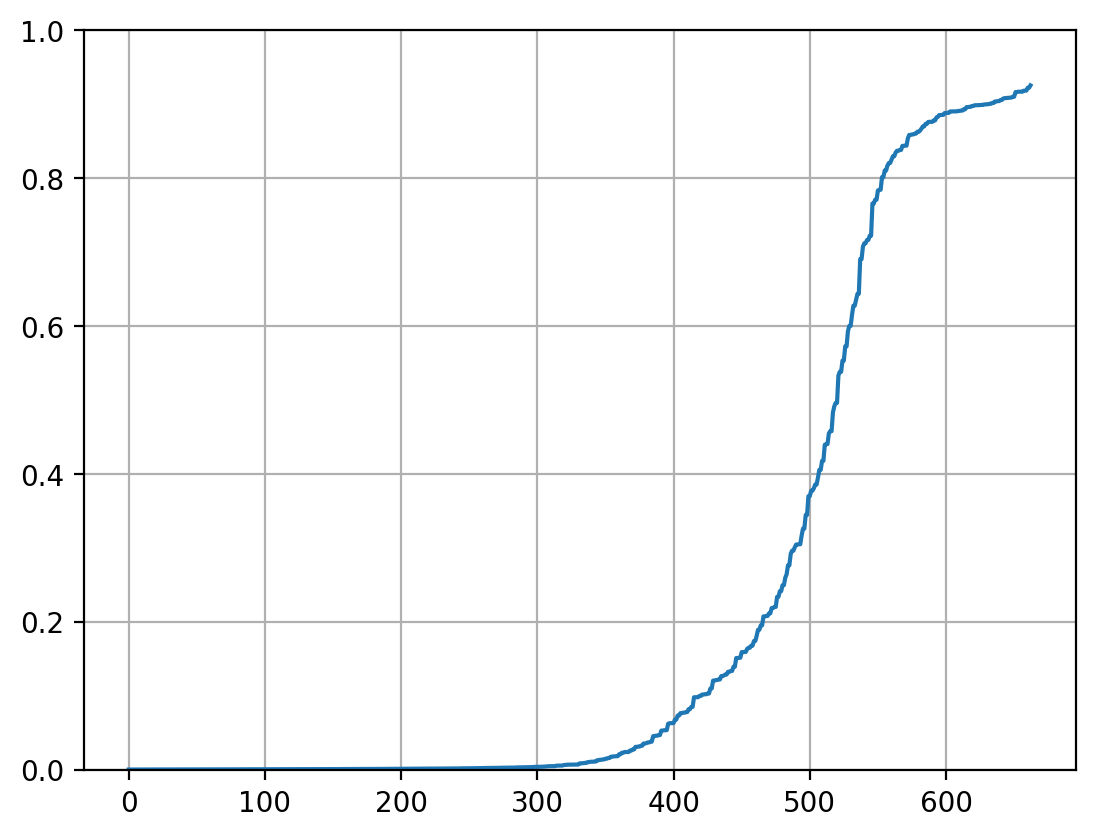

In [764]:
e, v = np.linalg.eig(A)
plt.plot(sorted(np.abs(e)))
plt.grid('on')
plt.ylim((0,1))

In [765]:
# State-space simulation
v = Theta[:,0]
y_hat_AB = [v]
x_hat = np.zeros(order)
for t in range(y_series.shape[0]-1):
    x_hat = A @ x_hat + B @ u_series[t,:]
    y_hat_AB.append( v + C @ x_hat )
y_hat_AB = np.array(y_hat_AB)   

In [766]:
# Markov parameters simulation
U = []
for t in range(y_series.shape[0]):
    if t < tau:
        U.append(np.zeros(tau*d))
    else:
        U.append( u_series[t-tau:t,:][::-1,:].reshape(-1) )
U = np.array(U)
U = np.concatenate( (np.ones((U.shape[0],1)),U), axis=1)
y_hat_Markov = U @ Theta.T

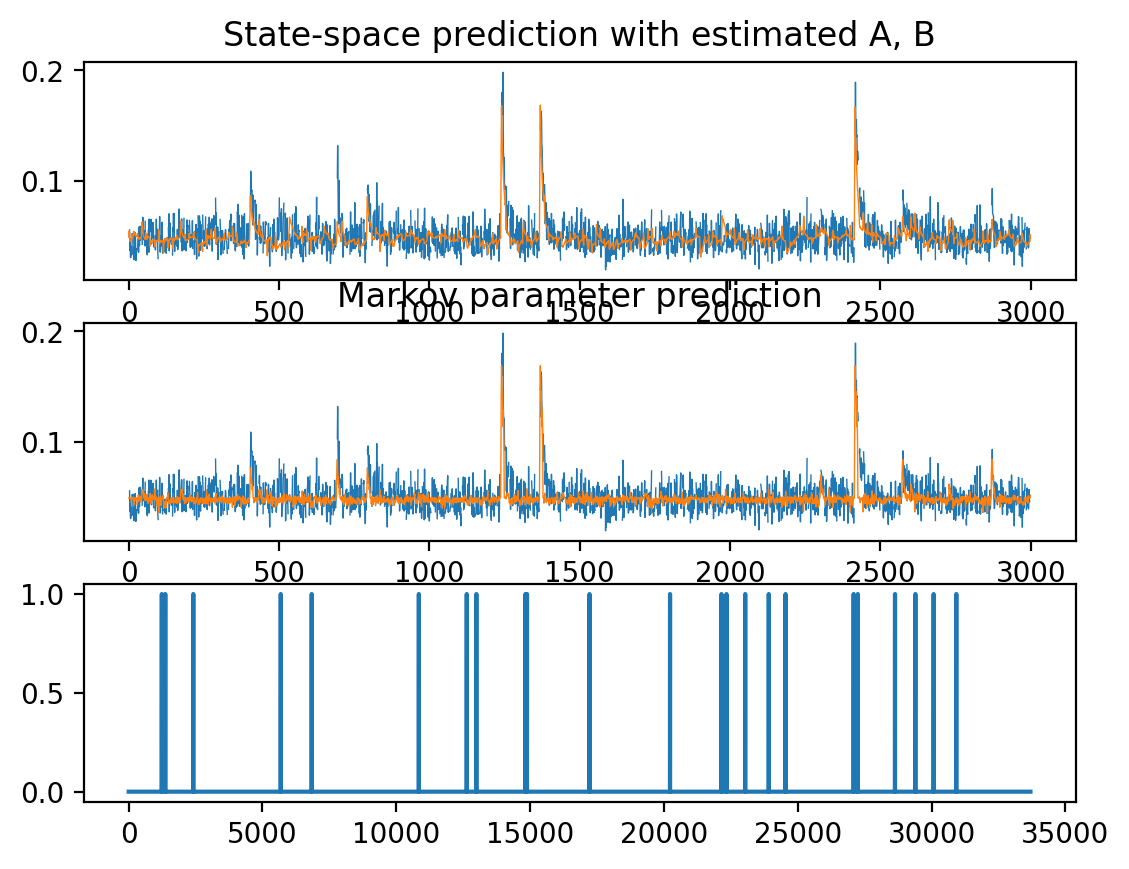

In [767]:
end=3000 # y_series.shape[0]

neuron = 19

plt.subplot(3,1,1)
plt.plot(y_series[0:end:,neuron],linewidth=.5)
plt.plot(y_hat_AB[0:end,neuron],alpha=1,linewidth=.5)
plt.title('State-space prediction with estimated A, B')

plt.subplot(3,1,2)
plt.plot(y_series[0:end:,neuron],linewidth=.5)
plt.plot(y_hat_Markov[0:end,neuron],alpha=1,linewidth=.5)
plt.title('Markov parameter prediction')

plt.subplot(3,1,3)
plt.plot(u_series[0:2*seq_length,neuron])
# plt.xlim((0,2000))
plt.show()

# Train model on linearly interpolated data (OLD)


In [240]:
y_series = torch.tensor(y_series, dtype=torch.float)
u_series = torch.tensor(u_series, dtype=torch.float)

def project_mat(A, eig_threshold = 0.5):
    L, V = torch.linalg.eig(A)
    L[L.abs()>eig_threshold] = L[L.abs()>eig_threshold]/L.abs()[L.abs()>eig_threshold]*eig_threshold
#     L = L/L.abs().max()
    return torch.real(V @ torch.diag(L) @ torch.linalg.inv(V))
        
        
class SigmoidModel(nn.Module):
    def __init__(self, dim):
        super(SigmoidModel, self).__init__()  
        self.A = nn.Linear(dim, dim, bias=False)
        self.A.weight.data *=.01
        self.B = nn.Linear(dim, dim, bias=False)
        self.c = nn.Parameter( torch.randn(dim)*0.01  )

    def forward(self, x, u):
        return  self.A(x-self.c) + self.B(u) + self.c
    
model = SigmoidModel(num_neurons)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=.001)


num_epochs = 50
for epoch in range(num_epochs):

    # Clamp the weights to be at least 0 -- assumes an excited neuron can't decrease other neuron's rate
    with torch.no_grad():  # Make sure to use no_grad to avoid affecting the computation graph
        model.B.weight.data.clamp_(min=0)
        model.A.weight.data = project_mat(model.A.weight.data, eig_threshold=(epoch+1)/num_epochs)
        
    model.train()

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass: Compute predicted y by passing X to the model
    x_pred = model.c.clone()
    loss = criterion(x_pred, y_series[0,:])
    for k in range(1,seq_length):
        x_pred = model(x_pred, u_series[k-1,:]).clamp_(min=0, max=1)
        if ~torch.isnan(y_series[k,0]):
            loss += criterion(x_pred, y_series[k,:]) / seq_length
    train_loss = loss.item()
#     loss += .1*torch.sum(model.A.weight**2)
#     largest_sing = torch.linalg.matrix_norm(model.A.weight, ord=2)
    
#     loss += 10*largest_sing**2
    train_obj = loss.item()

    
    
    
#     print(epoch, train_loss)
    # Backward pass: Compute gradient of the loss with respect to model parameters
    loss.backward()
    optimizer.step()

    largest_eig = torch.linalg.eigvals(model.A.weight).abs().max().item()
    print(epoch, train_loss, largest_eig, train_obj)
        
#         model.A.weight.data.clamp_(min=0)

        
# #   TEST:
#     model.eval()

#     x_pred = model.c.clone()
#     loss = criterion(x_pred, y_series[0,:])
#     for k in range(1,seq_length):
#         x_pred = model(x_pred, u_series[k-1,:])
#         if ~torch.isnan(y_series[k,0]):
#             loss += criterion(x_pred, y_series[k,:]) 
#     test_loss = loss.item()
    
#     # Forward pass: Compute predicted y by passing X to the model
#     y_pred = model(y_test_0_interp, u_test_0)
#     loss = criterion(y_pred, y_test_1_interp)  
#     test_loss = loss.item()
#     print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')

0 0.011874056421220303 0.16649064421653748 0.011874056421220303
1 0.011532194912433624 0.17008177936077118 0.011532194912433624
2 0.011229848489165306 0.18370257318019867 0.011229848489165306
3 0.010942810215055943 0.21240654587745667 0.010942810215055943
4 0.010712821036577225 0.2721283435821533 0.010712821036577225
5 0.010490315966308117 0.31879451870918274 0.010490315966308117
6 0.0102662593126297 0.36136627197265625 0.0102662593126297
7 0.010041354224085808 0.4029276967048645 0.010041354224085808
8 0.009817847050726414 0.44483575224876404 0.009817847050726414
9 0.009597185999155045 0.4860948622226715 0.009597185999155045
10 0.009379501454532146 0.5265858769416809 0.009379501454532146
11 0.009164899587631226 0.5661243796348572 0.009164899587631226
12 0.008952304720878601 0.609370231628418 0.008952304720878601
13 0.00874259416013956 0.6527489423751831 0.00874259416013956
14 0.008536046370863914 0.6973683834075928 0.008536046370863914
15 0.00833217240869999 0.7418779134750366 0.008332

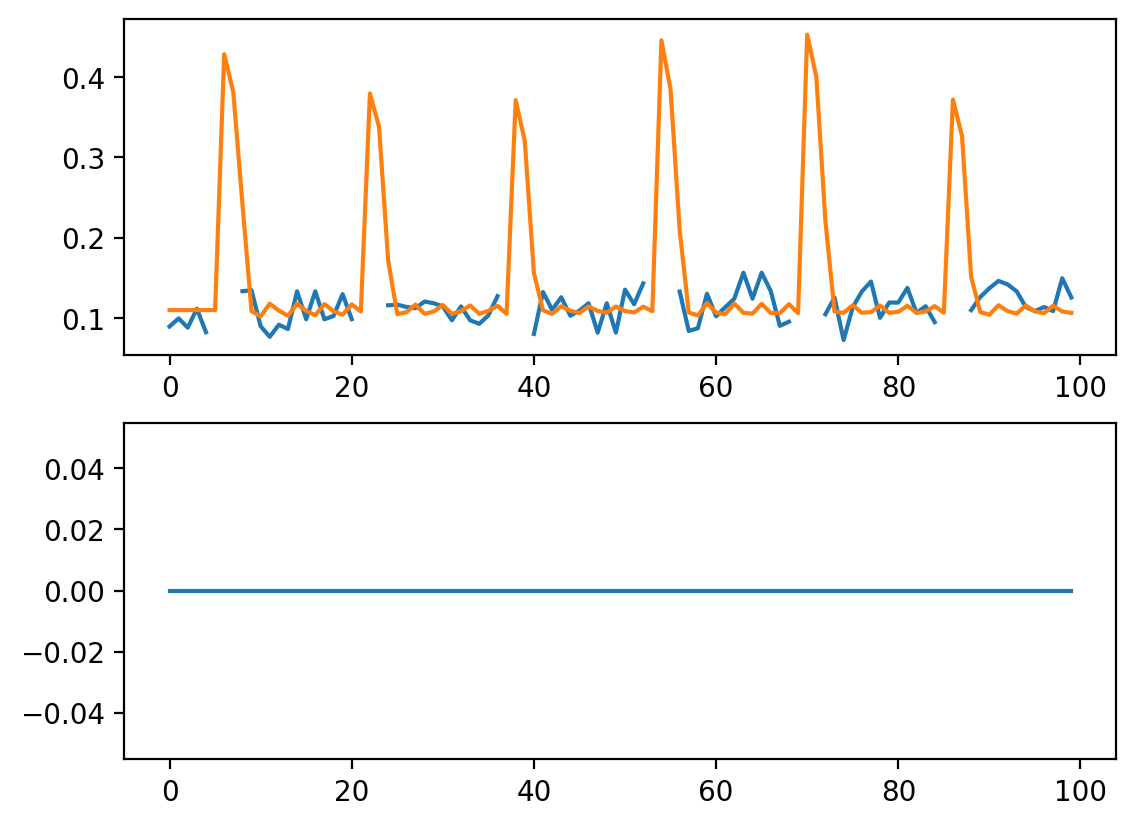

In [238]:
# model.A.weight.data = .98*project_mat(model.A.weight.data, eig_threshold=.98*(epoch+1)/num_epochs)
neuron = 0
start = 0
end = 100 # 2*seq_length

x_pred = model.c.clone()
y_hat = x_pred.unsqueeze(0)
for k in range(start+1,end):
    x_pred = model(x_pred, u_series[k-1,:])
    y_hat = torch.cat((y_hat, x_pred.unsqueeze(0)), dim=0) 

plt.subplot(2,1,1)
plt.plot(y_series[start:end,neuron])
plt.plot(y_hat.detach().numpy()[:,neuron])
plt.subplot(2,1,2)
plt.plot(u_series[start:end,neuron])
plt.show()

Text(0.5, 1.0, 'Causal matrix: B')

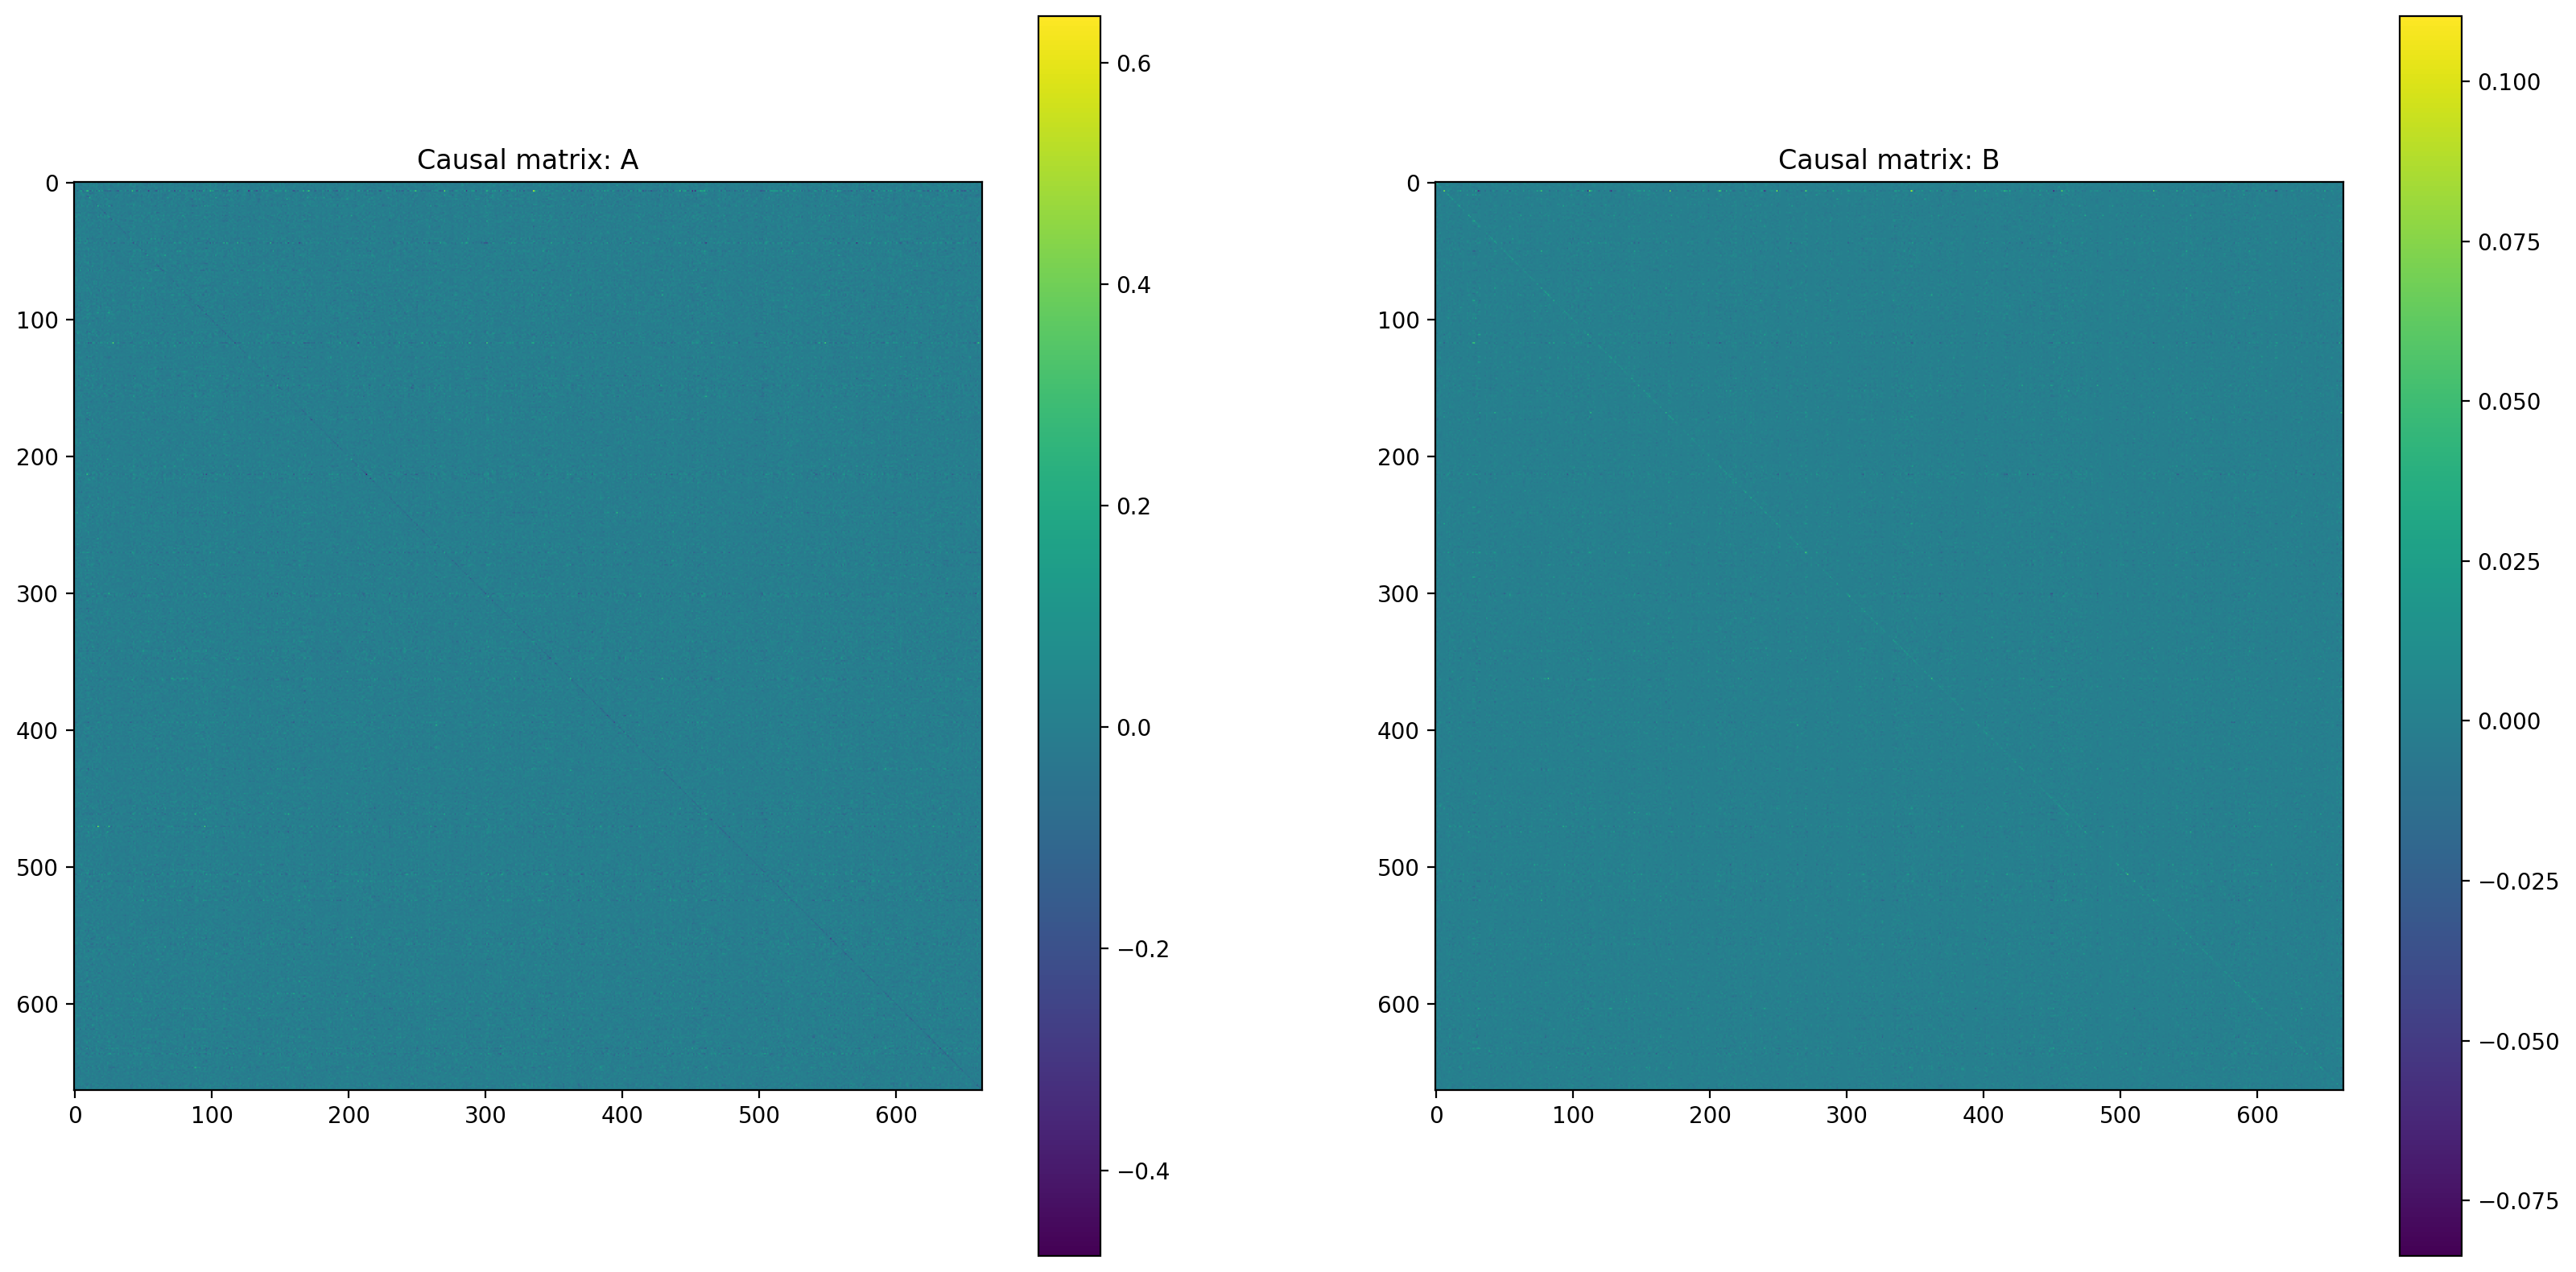

In [760]:
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(A) #, norm=colors.Normalize(vmin=0.0, vmax=.1))
plt.colorbar()
plt.title('Causal matrix: A')

plt.subplot(1,2,2)
plt.imshow(B) # , norm=colors.Normalize(vmin=0.0, vmax=.1))
plt.colorbar()
plt.title('Causal matrix: B')

<StemContainer object of 3 artists>

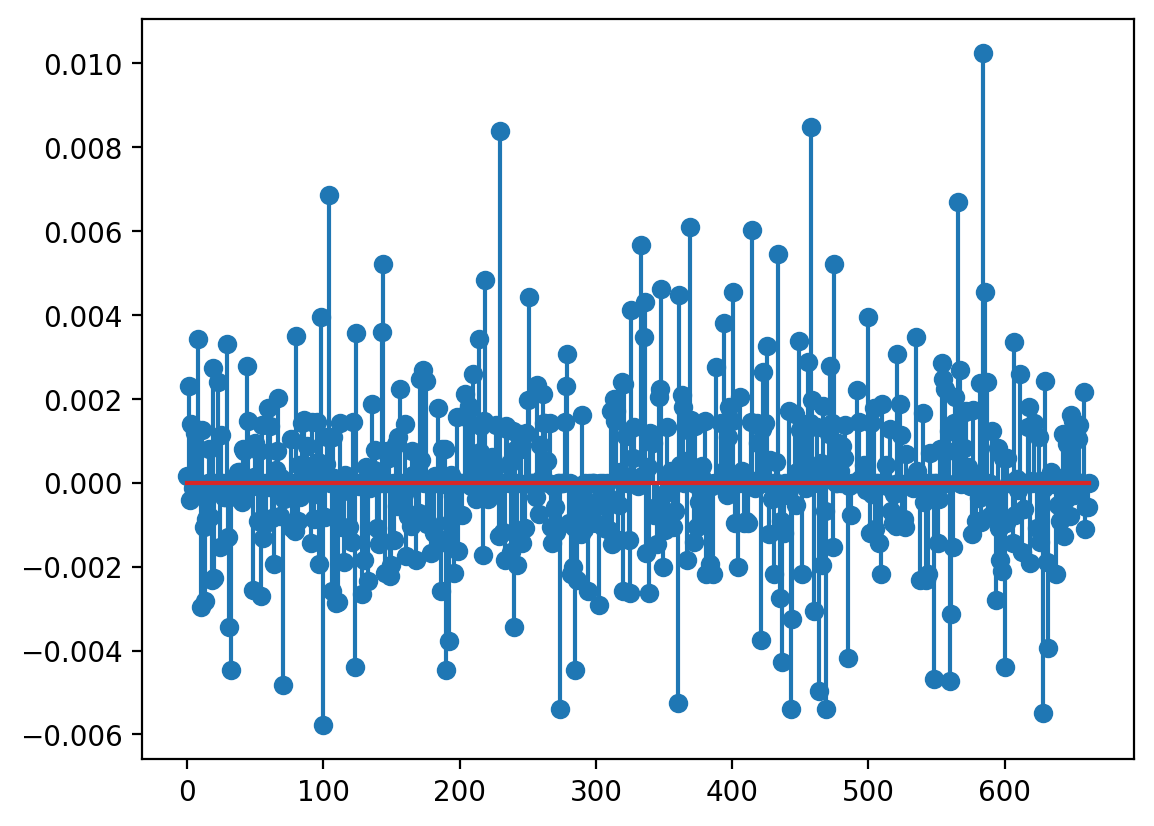

In [759]:
plt.stem(B[19])